# Pytorch tutorial

0. Data

In [1]:
from sklearn.datasets import load_digits

In [2]:
digits_dataset = load_digits()
print(list(digits_dataset.keys()))

['data', 'target', 'target_names', 'images', 'DESCR']


In [3]:
print(digits_dataset['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
print('data shape: ', digits_dataset['data'].shape)
print('images shape: ', digits_dataset['images'].shape)
print('labels shape: ', digits_dataset['target'].shape)

data shape:  (1797, 64)
images shape:  (1797, 8, 8)
labels shape:  (1797,)


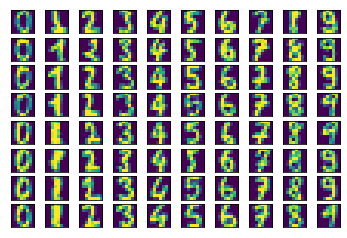

In [5]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
num_samples = 8
fig, ax = plt.subplots(num_samples, 10)

data = digits_dataset['data']
labels = digits_dataset['target']
for i in range(10):
    samples = np.random.choice(np.where(labels == i)[0], size=num_samples, replace=False)
    for s in range(num_samples):
        ax[s][i].matshow(data[samples[s], :].reshape(8, 8))
        ax[s][i].set_xticks([])
        ax[s][i].set_yticks([])
        ax[s][i].set_aspect('equal')



1. Prepare for training

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
print('training size: ', len(y_train))
print('training frequencies: ', dict(zip(*np.unique(y_train, return_counts=True))))
print('testing size: ', len(y_test))
print('testing frequencies: ', dict(zip(*np.unique(y_test, return_counts=True))))

training size:  1437
training frequencies:  {0: 142, 1: 146, 2: 142, 3: 146, 4: 145, 5: 145, 6: 145, 7: 143, 8: 139, 9: 144}
testing size:  360
testing frequencies:  {0: 36, 1: 36, 2: 35, 3: 37, 4: 36, 5: 37, 6: 36, 7: 36, 8: 35, 9: 36}


2. Data loader

In [7]:
# NOTE: make sure to set it before importing torch
%env CUDA_VISIBLE_DEVICES=0

import torch

from torch.utils import data as tu_data

class DigitsDataset(tu_data.Dataset):
    def __init__(self, data, labels):
        super(DigitsDataset, self).__init__()
        assert len(data)==len(labels)
        self._data = data
        self._labels = labels
        
    def __len__(self):
        return len(self._labels)
    
    def __getitem__(self, index):
        item = self._data[index, :].reshape(8, 8).astype(np.float32) / 16
        label = self._labels[index]
        return torch.from_numpy(item).unsqueeze_(0), torch.tensor(label).long()
    


env: CUDA_VISIBLE_DEVICES=0


In [8]:
train_set = DigitsDataset(X_train, y_train)
test_set = DigitsDataset(X_test, y_test)

data_loader_params = {'batch_size': 16,
                      'num_workers': 0,
                      'pin_memory': True}

generators = {'train': tu_data.DataLoader(train_set, shuffle=True, **data_loader_params),
              'test': tu_data.DataLoader(test_set, shuffle=False, **data_loader_params)}


3. Model

In [9]:
import torch.nn as nn


class DigitsClassifier(nn.Module):
    def __init__(self):
        super(DigitsClassifier, self).__init__()
        n = [16, 32, 64]
        self._feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n[0], kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(n[0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=n[0], out_channels=n[1], kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(n[1]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=n[1], out_channels=n[2], kernel_size=3, stride=1, padding=(1, 1), bias=False),
            nn.BatchNorm2d(n[2]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self._classifier = nn.Sequential(
            nn.Linear(n[2], out_features=n[2], bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(n[2], out_features=n[2], bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(n[2], out_features=n[2], bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(n[2], out_features=10, bias=True)
        )
        self._n = n

    def forward(self, xx):
        feats = self._feature_extractor(xx)
        classes = self._classifier(feats.view(-1, self._n[-1]))
        return classes


In [10]:
model = DigitsClassifier()
print(model)


DigitsClassifier(
  (_feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (_classifier): Sequential(
    (0): Linear(in_features=64, o

4. Optimizer

In [11]:
import torch.optim as optim

INITIAL_LR = 1e-3
#optimizer = optim.Adam(model.parameters(), lr=LR)
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR)


5. Loss function



In [12]:
loss = nn.CrossEntropyLoss(reduction='sum')

\begin{equation*}
loss(x, class) = -\log\Bigl({\frac{\exp(x[class])}{\sum_{j}\exp(x[j])}}\Bigr)= -x[class] + \log\Bigl(\sum_{j}\exp(x[j])\Bigr)
\end{equation*}

# 6. Training

6.1 CUDA

In [13]:
use_cuda = torch.cuda.is_available()
use_data_parallel = False
if use_cuda:
    from torch.backends import cudnn
    cudnn.benchmark = True
    print('cudnn version', torch.backends.cudnn.version())
    print('number of cuda devices:', torch.cuda.device_count())
    use_data_parallel = torch.cuda.device_count() > 1
    for cuda_device in range(torch.cuda.device_count()):
        print('%d: %s' % (cuda_device, torch.cuda.get_device_name(cuda_device)))
    
device = torch.device("cuda" if use_cuda else "cpu")
print('training on %s' % device)


training on cpu


6.2 Move to correct device

In [14]:
if use_data_parallel:
    model = nn.DataParallel(model)

model = model.to(device)
loss = loss.to(device)

6.3 Training loop

In [15]:
from tqdm.auto import tqdm

losses = {'train':[], 'test':[]}


In [16]:

MAX_EPOCHS = 64
LR = INITIAL_LR
# LR = INITIAL_LR * 0.01

# update learning rate (if re-run)
for g in optimizer.param_groups:
    g['lr'] = LR

for epoch in tqdm(range(MAX_EPOCHS)):
    for mode in generators:
        
        if mode is 'train':
            model.train()
        elif mode is 'test':
            model.eval()
        
        progress_bar = tqdm(enumerate(generators[mode]), total=len(generators[mode]))
        
        epoch_loss_value = 0
        
        for idx, (images, targets) in progress_bar:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(mode is 'train'):
                outputs = model(images.to(device))
                loss_value = loss(outputs, targets)
                loss_item = loss_value.item()

                epoch_loss_value += loss_item
                progress_bar.set_description(
                    '{:5s} {:3d} LOSS {:4.8f}'.format(mode, epoch, loss_item))
                if mode is 'train':
                    loss_value.backward()
                    optimizer.step()
        
        epoch_loss_value /= len(generators[mode])
        losses[mode].append(epoch_loss_value)




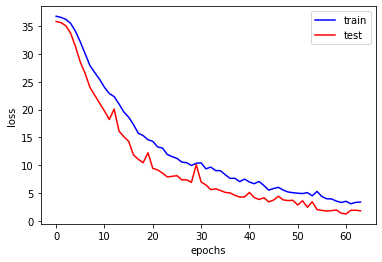

In [17]:
plt.figure()
plt.plot(losses['train'], 'b-', label='train')
plt.plot(losses['test'], 'r-', label='test')
plt.gca().legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

7. Inference

In [18]:
from sklearn.metrics import accuracy_score

def compute_accuracy(model_, data_, labels_):
    model_.eval()
    data_ = torch.from_numpy(data_.astype(np.float32)).view(-1, 1, 8, 8)
    data_= data_.to(device)
    _, result_ = torch.max(model_(data_), 1)
    result_ = result_.cpu().numpy()
    return accuracy_score(labels_, result_)

In [19]:
# accuracy
print('train accuracy: %4.8f' % compute_accuracy(model, X_train, y_train))
print('test accuracy: %4.8f' % compute_accuracy(model, X_test, y_test))


train accuracy: 0.76548365
test accuracy: 0.72777778
